# Step 1: Import Libraries

In [2]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, BatchNormalization, Dropout


2024-04-27 10:16:24.696643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 10:16:24.696745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 10:16:24.846434: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Step 2: Define Helper Functions for Data Processing
Function to Load ECG Data

In [3]:
def load_ecg_data(record_path):
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr')
    ecg_signal = record.p_signal[:, 0]
    r_peaks = annotation.sample
    
    # Apply baseline drift removal and bandpass filter
    ecg_signal = remove_baseline_drift(ecg_signal)
    ecg_signal = bandpass_filter(ecg_signal, low_freq=0.5, high_freq=40, fs=500)
    
    return ecg_signal, r_peaks


# Function to Remove Baseline Drift

In [4]:
def remove_baseline_drift(signal, wavelet="db6", level=9):
    coeff = pywt.wavedec(signal, wavelet, level=level)
    coeff[0] = np.zeros_like(coeff[0])  # Remove baseline drift
    reconstructed_signal = pywt.waverec(coeff, wavelet)
    return reconstructed_signal


# Function to Apply Bandpass Filter

In [5]:
def bandpass_filter(signal, low_freq, high_freq, fs, order=5):
    nyquist = 0.5 * fs
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal


# Function to Normalize and Segment the Signal

In [6]:
def normalize_and_segment(signal, r_peaks, window_size=180):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    signal_normalized = scaler.fit_transform(signal.reshape(-1, 1)).flatten()

    segments = []
    half_window = window_size // 2
    for r_peak in r_peaks:
        start = max(r_peak - half_window, 0)
        end = min(r_peak + half_window, len(signal_normalized))
        if end - start == window_size:
            segments.append(signal_normalized[start:end])
    return np.array(segments)


# Function to Process All Records

In [7]:
def load_and_process_all_records(base_directory, visualize=False):
    all_segments = []
    all_labels = []
    person_dirs = [d for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]
    lis =  ['Person_01', 'Person_02','Person_09', 'Person_10' ]
    print(person_dirs)
    for person_id in lis:
        person_path = os.path.join(base_directory, person_id)
        for record_file in os.listdir(person_path):
            if record_file.endswith('.dat'):
                record_base = record_file[:-4]
                record_path = os.path.join(person_path, record_base)
                ecg_signal, r_peaks = load_ecg_data(record_path)
                segments = normalize_and_segment(ecg_signal, r_peaks)
                all_segments.extend(segments)
                all_labels.extend([person_id] * len(segments))
                if visualize and person_id == 'Person_01':  # Example visualization for one person
                    visualize_ecg_signals(ecg_signal, segments, r_peaks, record_base)

    return np.array(all_segments), np.array(all_labels)


# Step 3: Visualize ECG Signals

In [8]:
def visualize_ecg_signals(ecg_signal, segments, r_peaks, record_label):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(ecg_signal, label='Filtered ECG Signal')
    plt.scatter(r_peaks, [ecg_signal[j] for j in r_peaks], color='red', label='R-peaks')
    plt.title(f'ECG Signal: {record_label}')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(segments[0], label='First Processed Segment')
    plt.title('First Segment After Processing')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Step 4: Build and Train the Model

In [9]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

['Person_07', 'Person_40', 'Person_38', 'Person_30', 'Person_39', 'Person_10', 'Person_87', 'Person_58', 'Person_85', 'Person_79', 'Person_84', 'Person_22', 'Person_48', 'Person_41', 'Person_23', 'Person_75', 'Person_35', 'Person_25', 'Person_31', 'Person_20', 'Person_76', 'Person_60', 'Person_68', 'Person_61', 'Person_82', 'Person_50', 'Person_47', 'Person_89', 'Person_16', 'Person_67', 'Person_65', 'Person_56', 'Person_12', 'Person_59', 'Person_51', 'Person_71', 'Person_09', 'Person_37', 'Person_78', 'Person_77', 'Person_27', 'Person_29', 'Person_18', 'Person_03', 'Person_42', 'Person_62', 'Person_06', 'Person_28', 'Person_05', 'Person_63', 'Person_13', 'Person_21', 'Person_49', 'Person_15', 'Person_70', 'Person_01', 'Person_69', 'Person_46', 'Person_54', 'Person_74', 'Person_11', 'Person_72', 'Person_81', 'Person_88', 'Person_64', 'Person_02', 'Person_66', 'Person_43', 'Person_90', 'Person_45', 'Person_36', 'Person_08', 'Person_83', 'Person_32', 'Person_80', 'Person_52', 'Person_14'

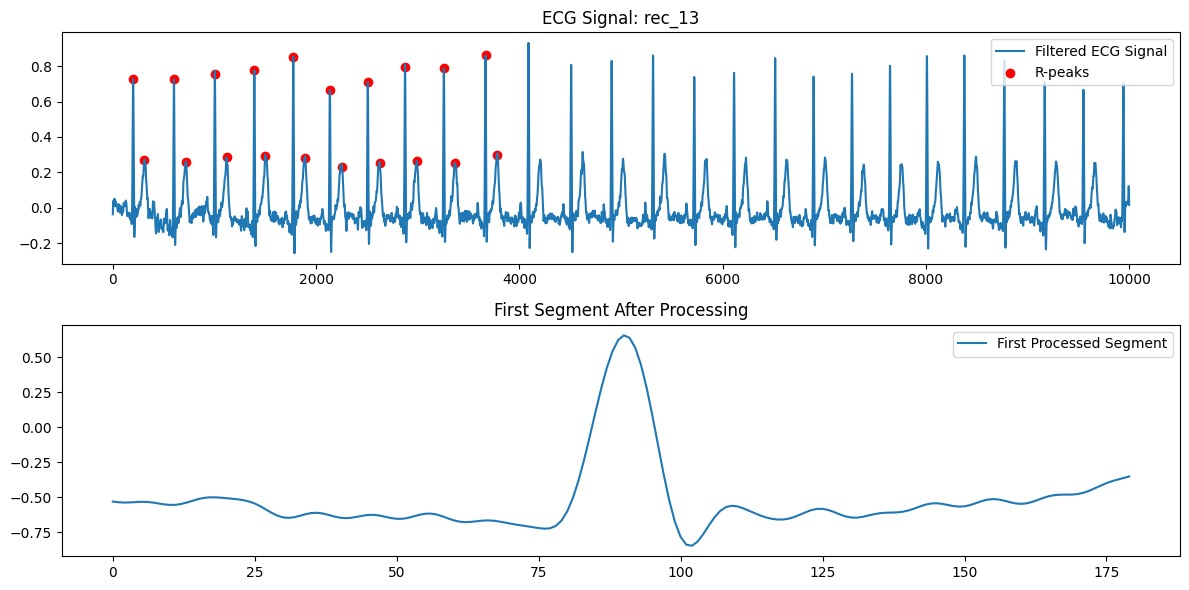

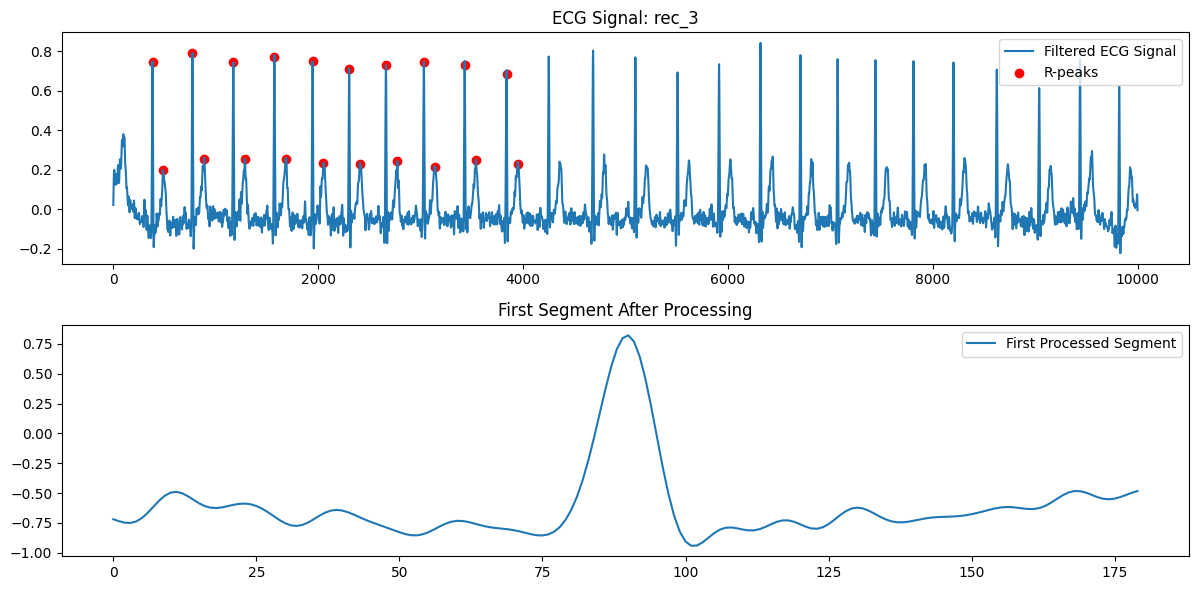

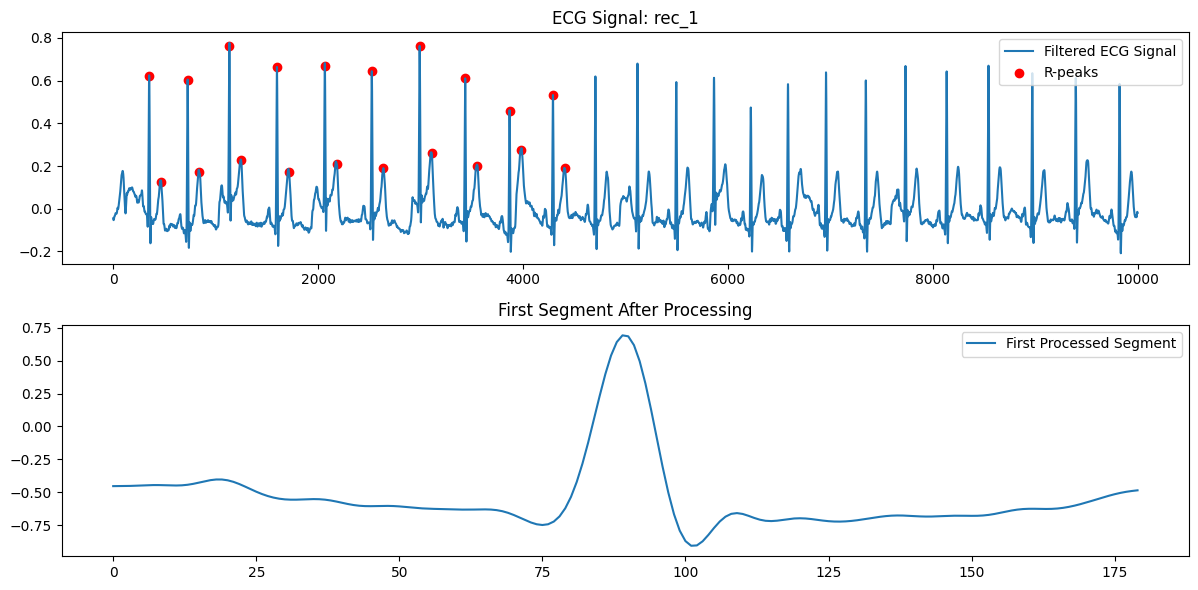

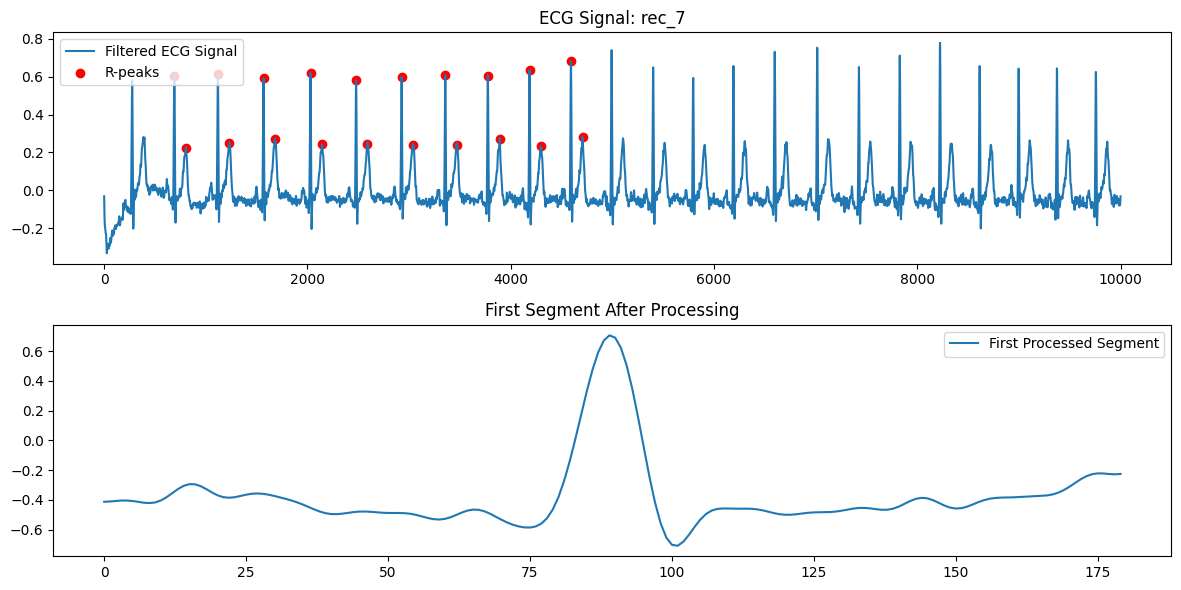

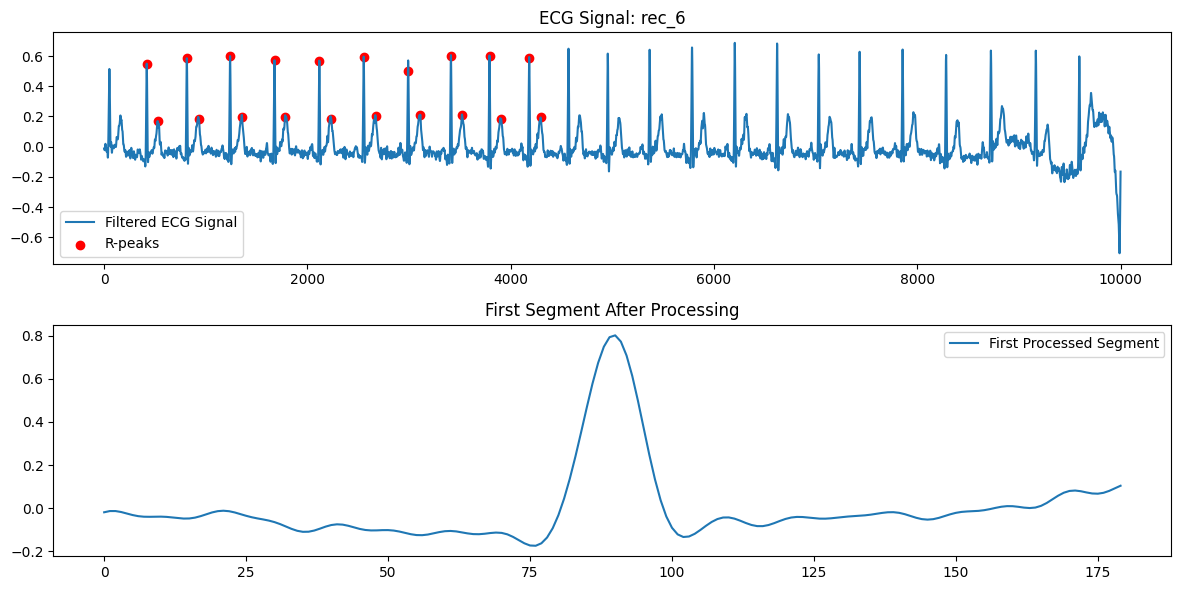

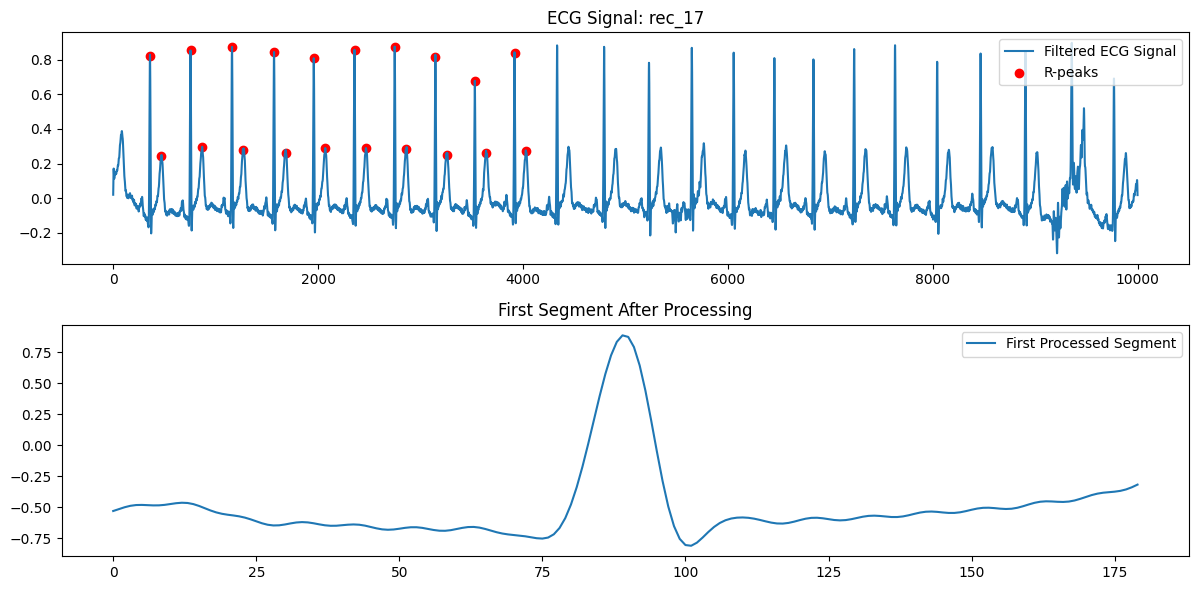

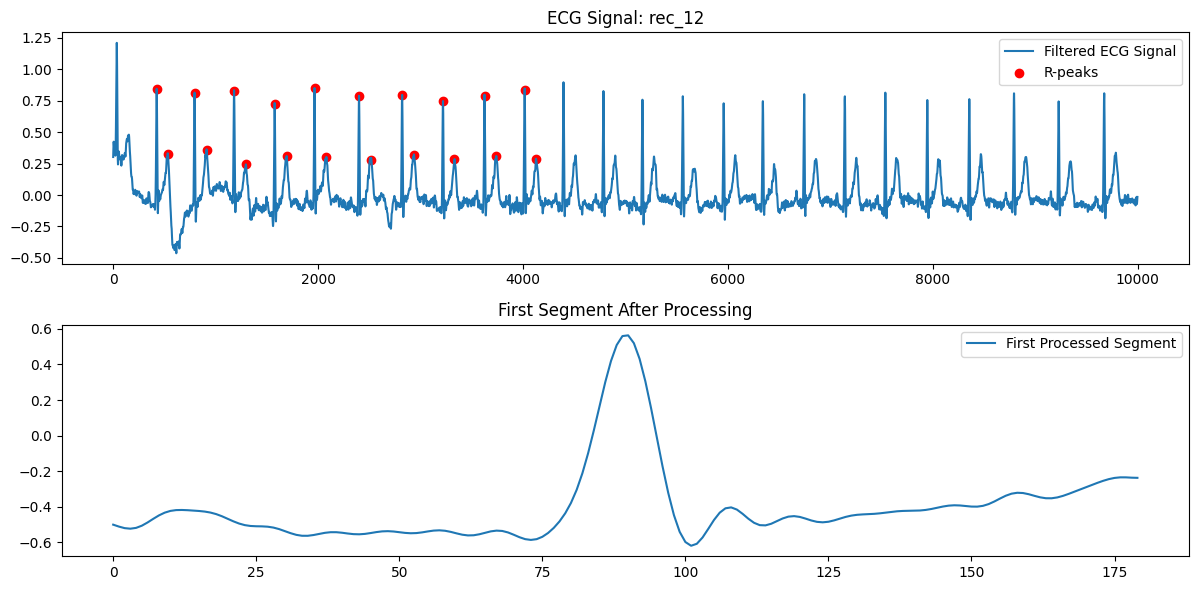

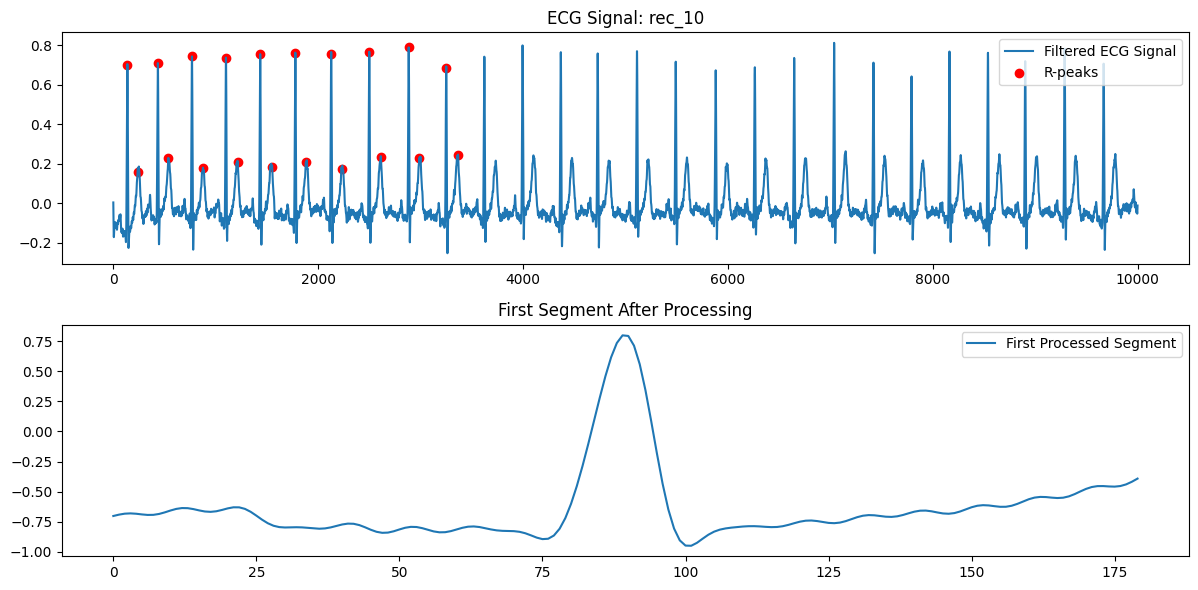

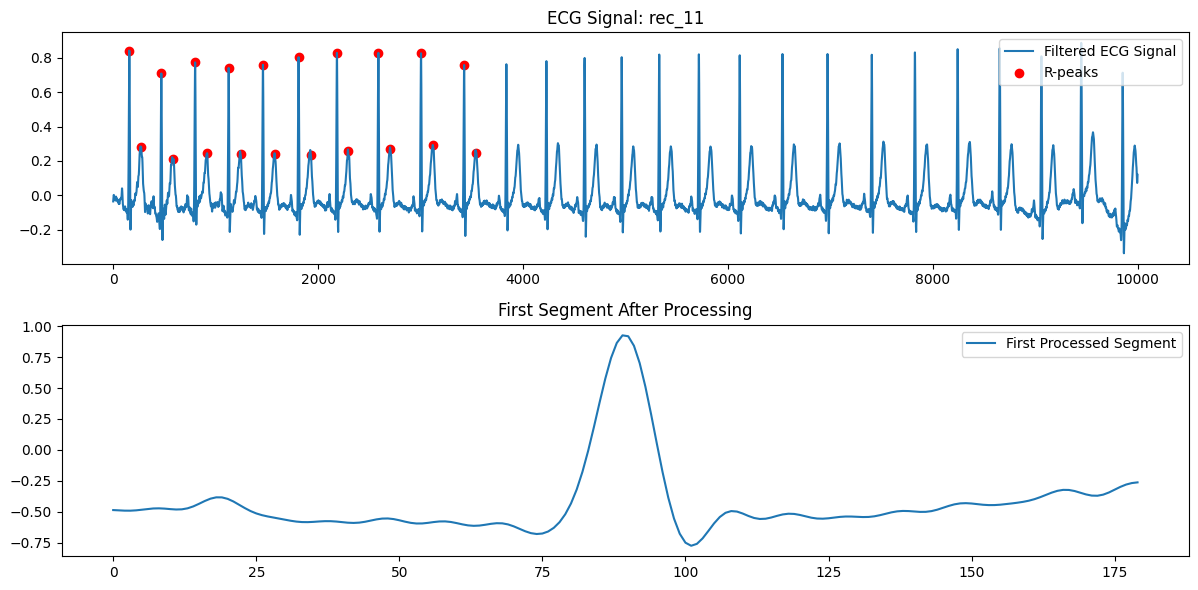

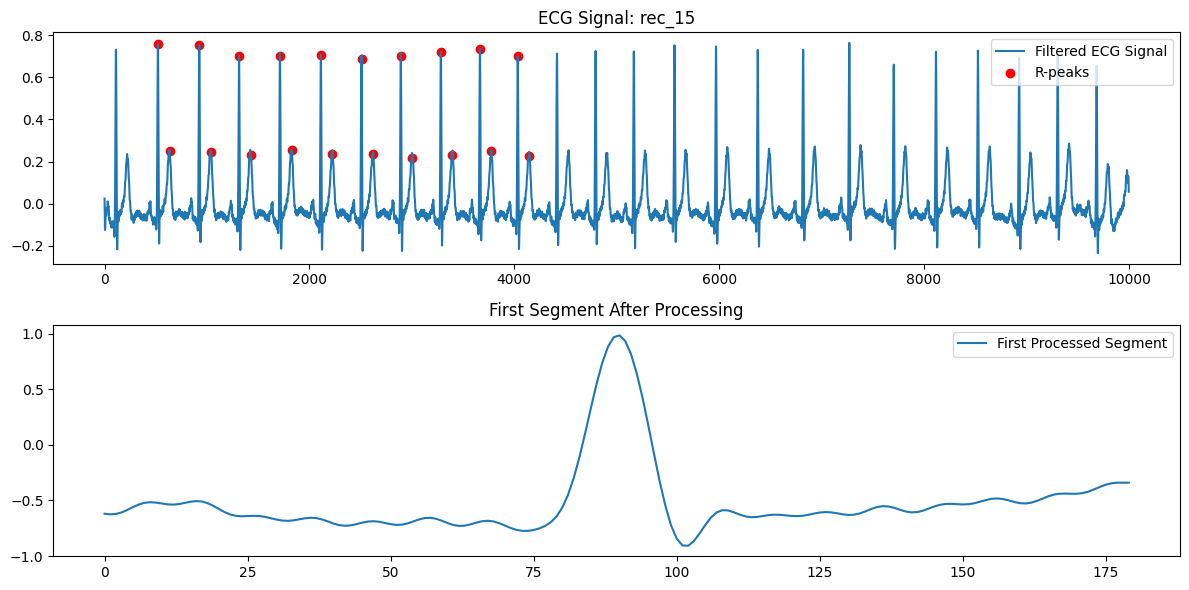

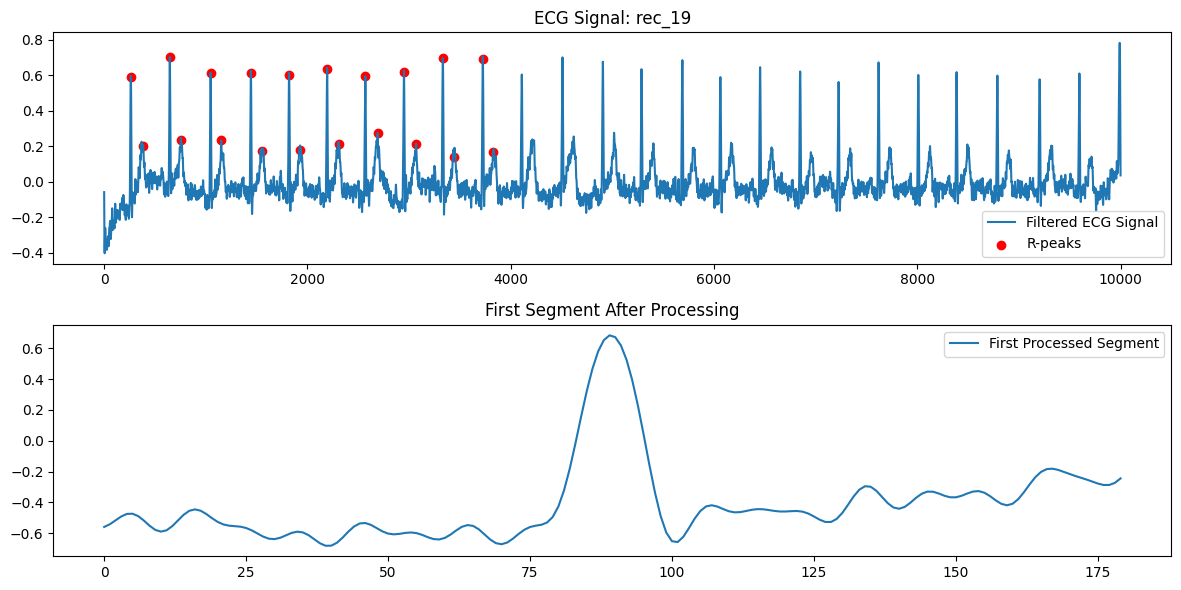

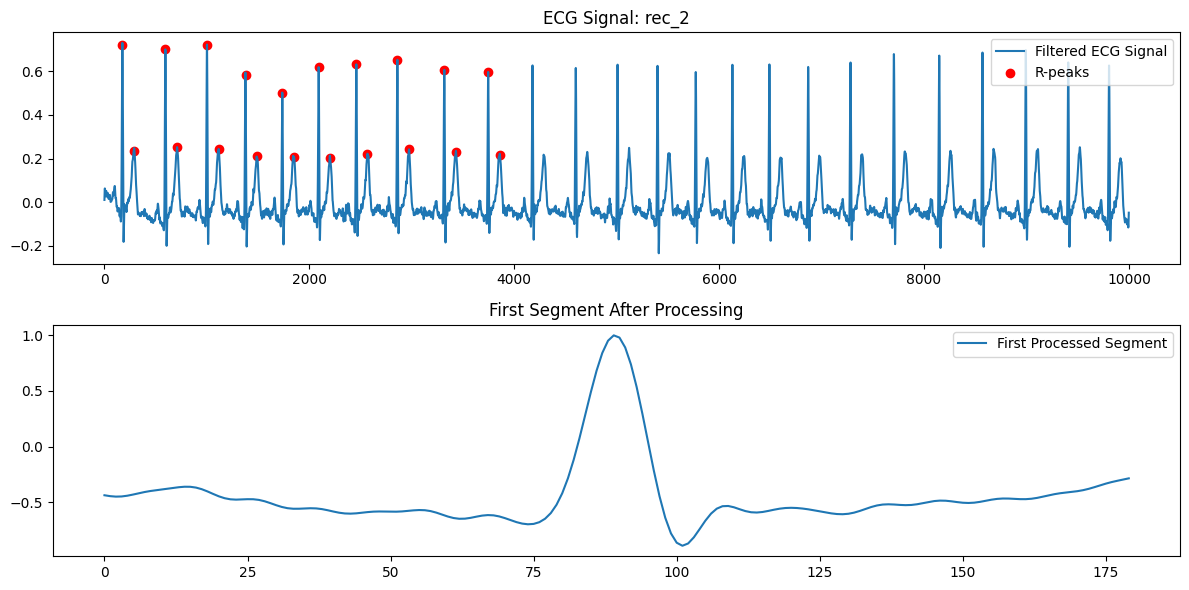

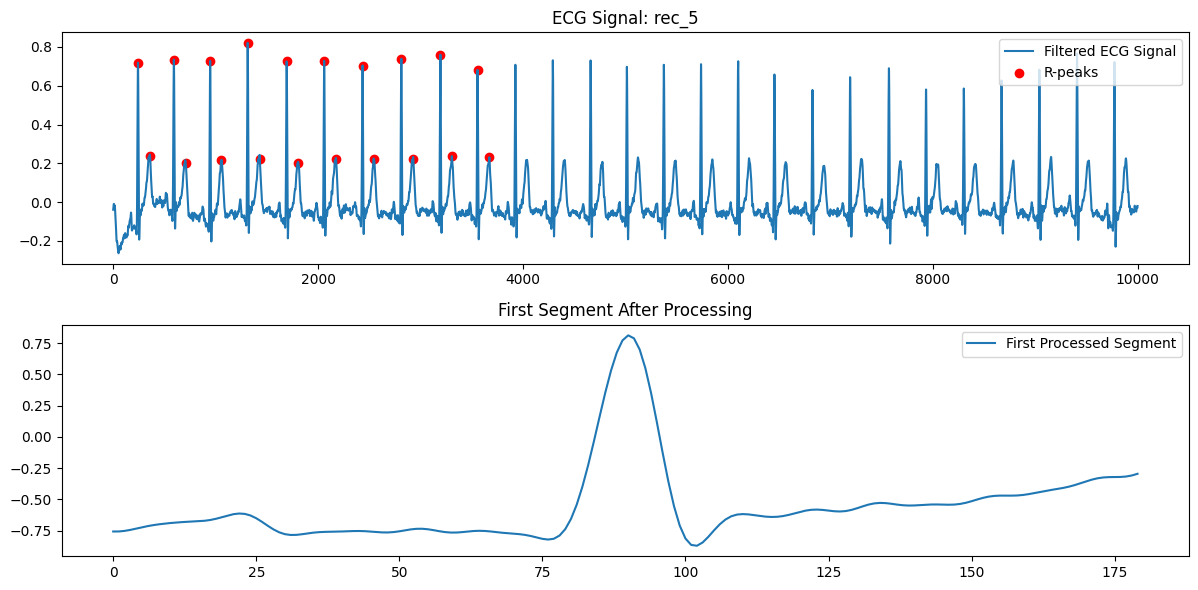

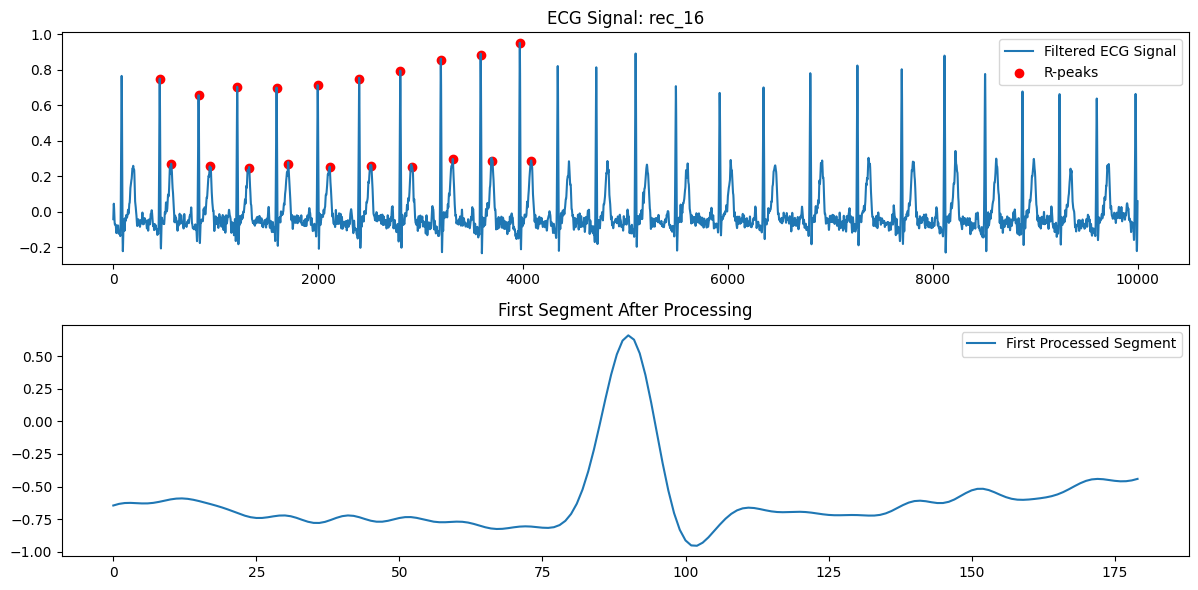

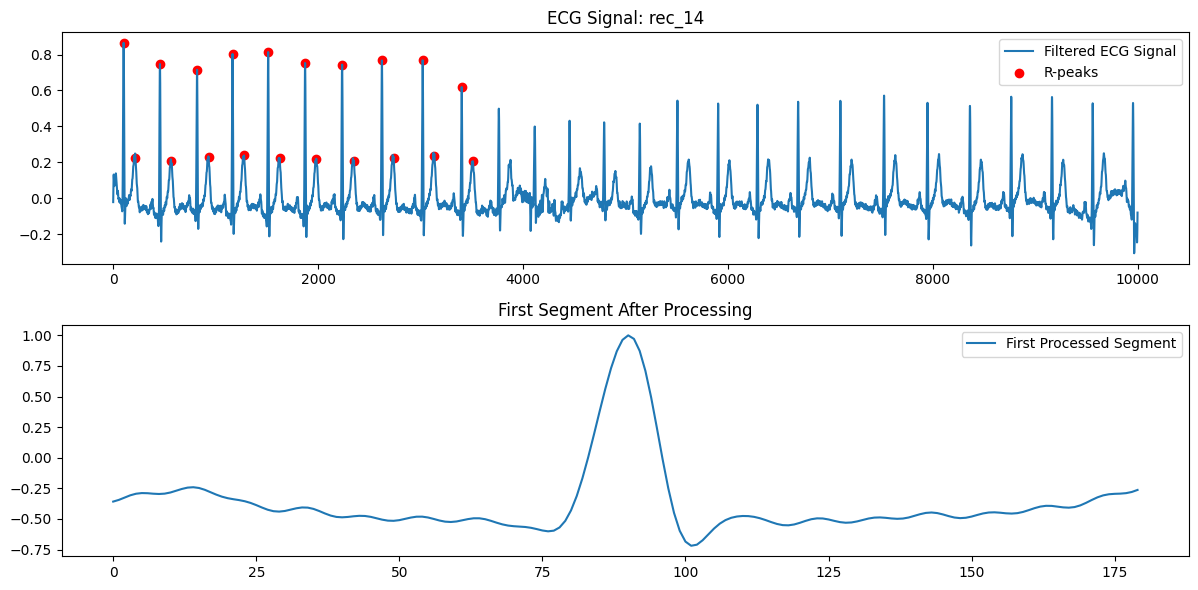

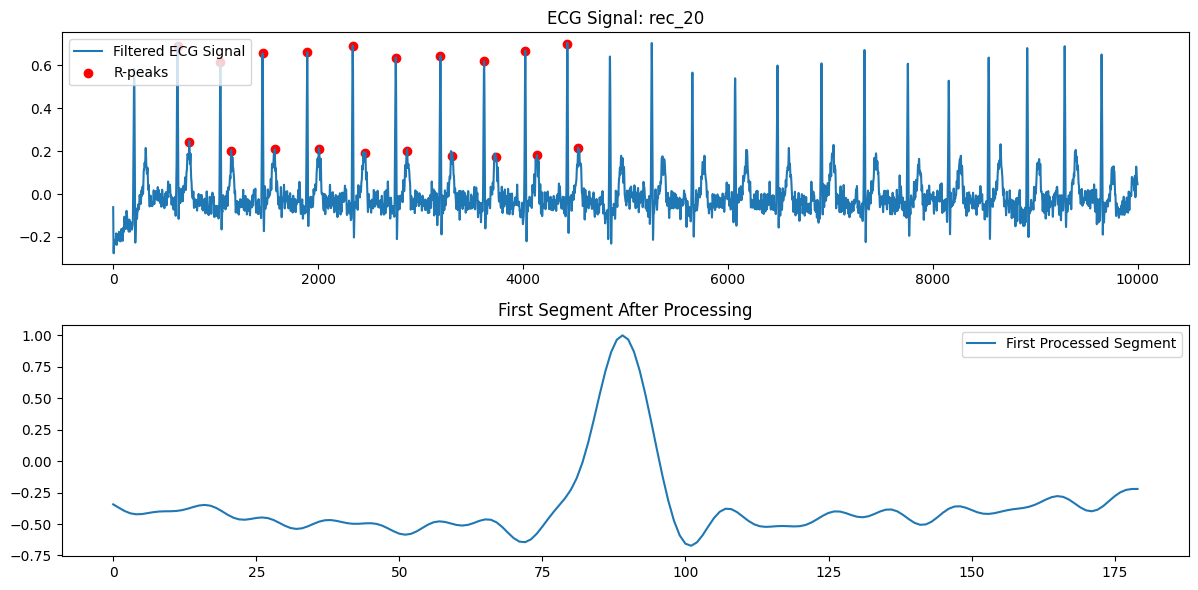

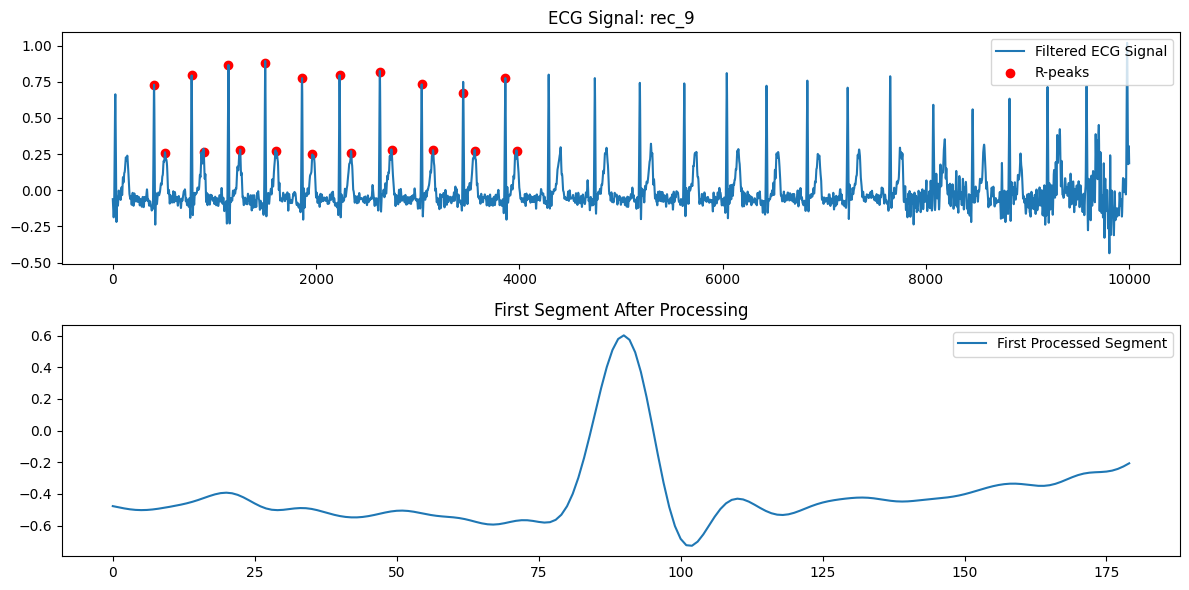

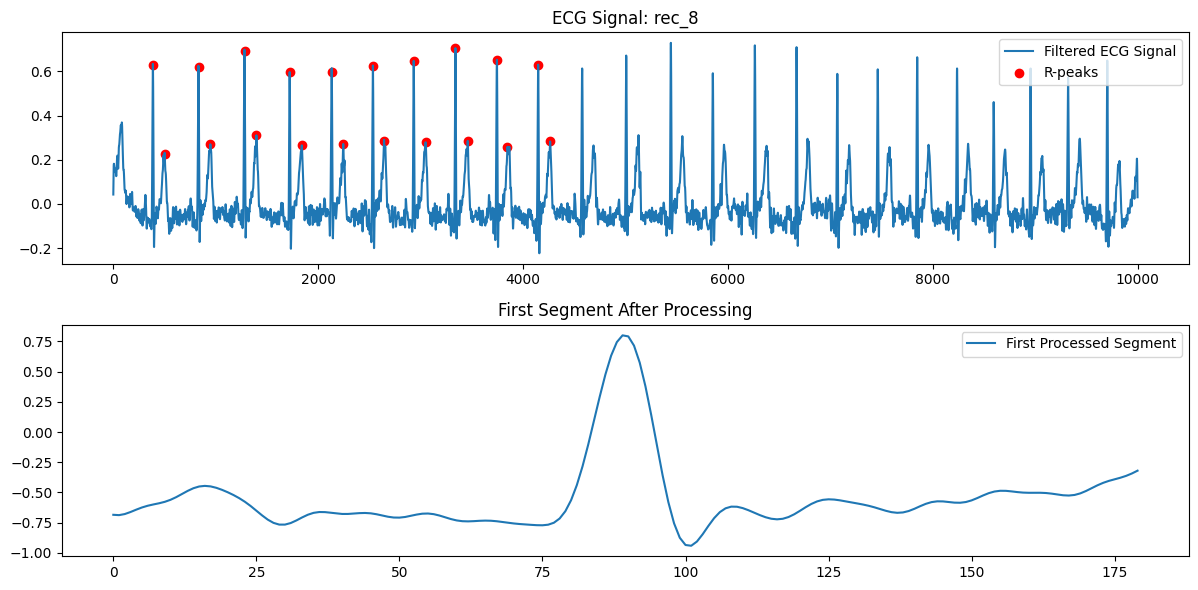

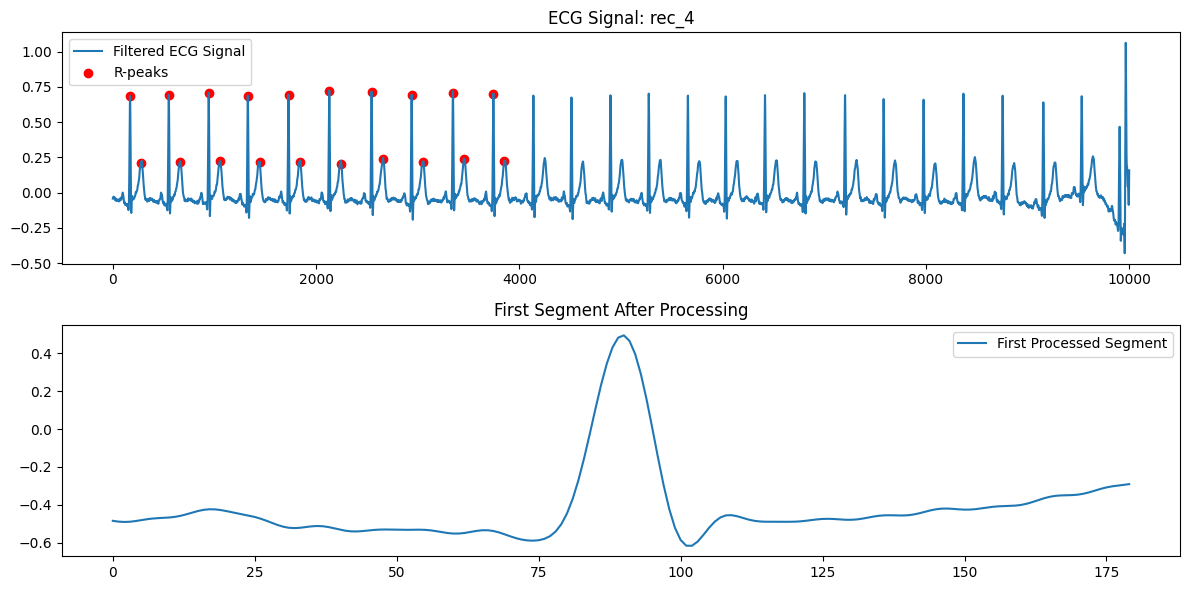

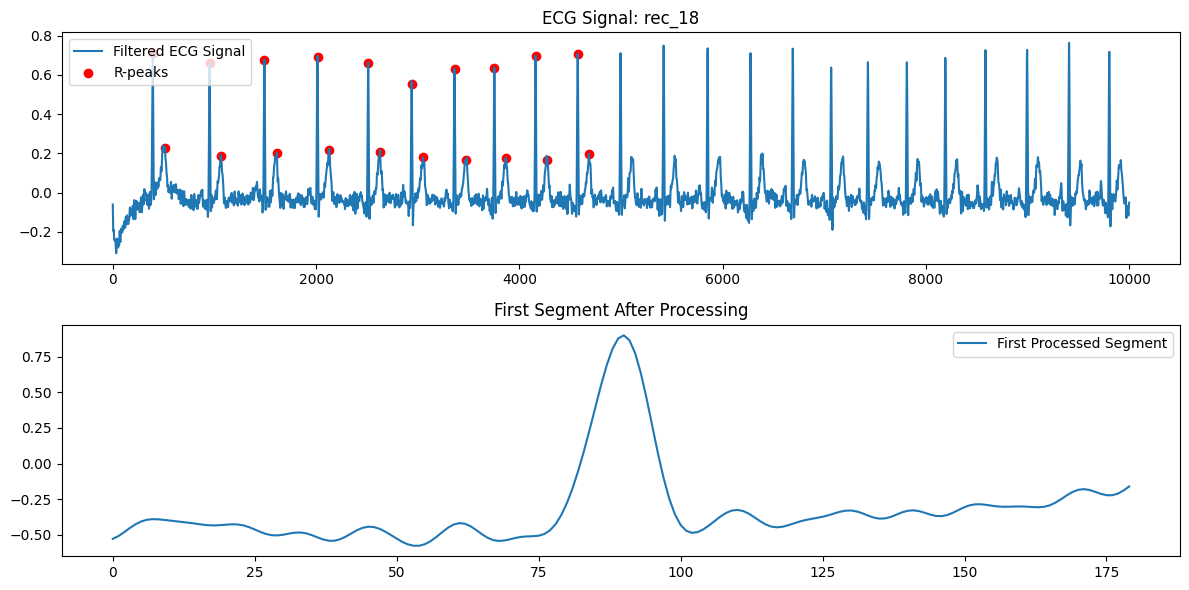

Epoch 1/50


I0000 00:00:1714213034.510587     132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 [==============================] - 26s 321ms/step - loss: 0.8810 - accuracy: 0.6527 - val_loss: 1.3492 - val_accuracy: 0.4393
Epoch 2/50
22/22 [==============================] - 3s 141ms/step - loss: 0.7272 - accuracy: 0.7395 - val_loss: 1.3343 - val_accuracy: 0.4393
Epoch 3/50
22/22 [==============================] - 3s 142ms/step - loss: 0.6053 - accuracy: 0.7699 - val_loss: 1.3815 - val_accuracy: 0.4393
Epoch 4/50
22/22 [==============================] - 3s 143ms/step - loss: 0.5967 - accuracy: 0.7728 - val_loss: 1.3889 - val_accuracy: 0.4393
Epoch 5/50
22/22 [==============================] - 3s 143ms/step - loss: 0.5566 - accuracy: 0.7800 - val_loss: 1.3362 - val_accuracy: 0.4393
Epoch 6/50
22/22 [==============================] - 3s 143ms/step - loss: 0.5357 - accuracy: 0.7974 - val_loss: 1.5122 - val_accuracy: 0.4220
Epoch 7/50
22/22 [==============================] - 3s 145ms/step - loss: 0.4808 - accuracy: 0.8177 - val_loss: 1.4864 - val_accuracy: 0.4277
Epoch 8/50
22/22

In [10]:
base_directory = 'data'
all_segments, all_labels = load_and_process_all_records(base_directory, visualize=True)

# Encoding labels
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels)

# Prepare data for the LSTM model
X = np.array(all_segments).reshape((len(all_segments), -1, 1))
y = np.array(all_labels_encoded)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the BiLSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),  # Adding dropout for regularization
    BatchNormalization(),  # Normalize the activations from the LSTM layer

    Bidirectional(LSTM(512, return_sequences=True)),
    # Additional LSTM layer with sequence return
    Dropout(0.2),  # More dropout for regularization
    BatchNormalization(),  # More normalization
     Bidirectional(LSTM(256, return_sequences=True)),
    # Additional LSTM layer with sequence return
    Dropout(0.2),  # More dropout for regularization
    BatchNormalization(),
     Bidirectional(LSTM(128, return_sequences=True)),
    # Additional LSTM layer with sequence return
    Dropout(0.2),  # More dropout for regularization
    BatchNormalization(),
    Bidirectional(LSTM(64)),  # Final LSTM layer without sequence return
#     Dropout(0.2),  # Dropout after final LSTM layer
    Dense(128, activation='relu'),  # An additional Dense layer for more complex transformations
#     Dropout(0.2),  # Dropout after Dense layer
    Dense(len(np.unique(y_train)), activation='softmax')  # Output layer
])

optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')


7/7 [==============================] - 4s 62ms/step


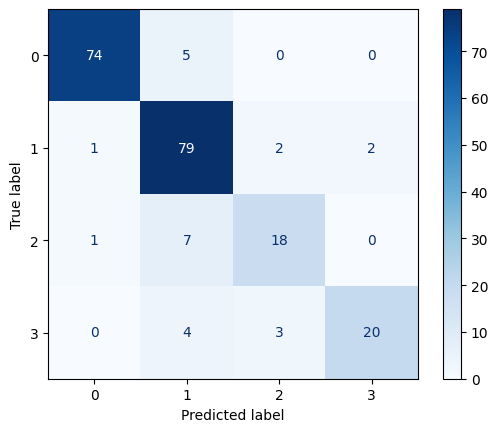

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


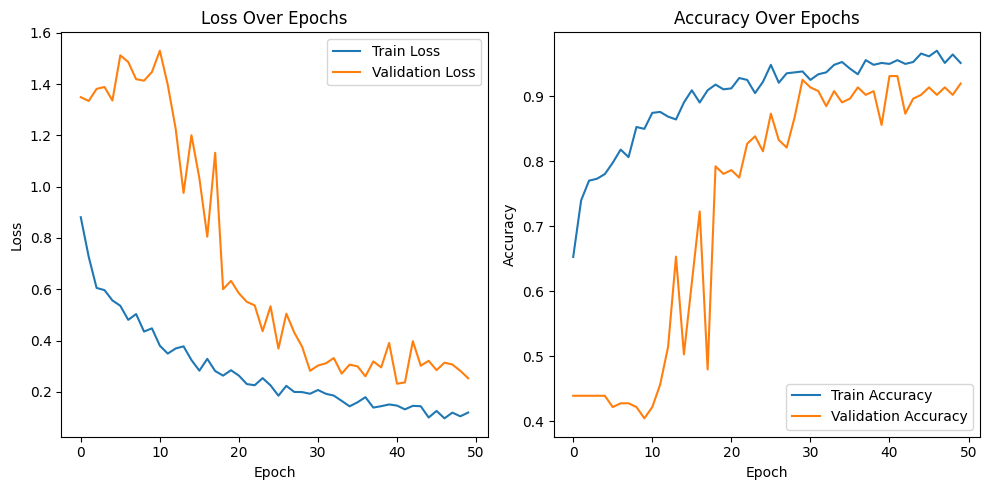

F1 Score: 0.8471351705216237


In [13]:
from sklearn.metrics import f1_score
# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate F1 Score for test set
y_true = y_test  # true labels
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 Score:', f1)


In [14]:
from sklearn.metrics import classification_report

#  `y_test` are the true labels and `y_pred` are the predicted labels from model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate classification report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)
 

7/7 [==============================] - 0s 50ms/step
              precision    recall  f1-score   support

   Person_01       0.97      0.94      0.95        79
   Person_02       0.83      0.94      0.88        84
   Person_09       0.78      0.69      0.73        26
   Person_10       0.91      0.74      0.82        27

    accuracy                           0.88       216
   macro avg       0.87      0.83      0.85       216
weighted avg       0.89      0.88      0.88       216



In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 180, 128)          33792     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 180, 128)          0         
                                                                 
 batch_normalization (Batch  (None, 180, 128)          512       
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 180, 1024)         2625536   
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 180, 1024)         0         
                                                        

In [16]:
model.save('modelf.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
np.save('labels.npy', all_labels)